In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from time import perf_counter, sleep

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=120, 
                                   horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                 target_size = (299,299),
                                                 batch_size = 16,
                                                #  batch_size = 128,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")

start
Found 221 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
end


In [ ]:
# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=input_tensor)

# Freeze the layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax',)(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("1")

1


In [ ]:
# Train the model on the data
# Validation_data – 모델에 대한 손실 평가 및 메트릭에 대해 고려할 데이터입니다.
# Class_weight - 는 클래스의 사전 인덱스를 손실 함수 계산에 추가로 사용되는 해당 float 또는 weight 값으로 매핑하기 위한 선택적 매개변수입니다.
start = perf_counter()
history = model.fit_generator(train_set, epochs = 12, validation_data = val_set)
end = perf_counter()
print(f"Time : {end-start}")

<ipython-input-90-aa7293626044>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set, epochs = 12, validation_data = val_set)


Epoch 1/12
14/14 [==============================] - 13s 932ms/step - loss: 0.1894 - accuracy: 0.9548 - val_loss: 0.6483 - val_accuracy: 0.7945
Epoch 2/12
14/14 [==============================] - 12s 874ms/step - loss: 0.0917 - accuracy: 0.9819 - val_loss: 0.6939 - val_accuracy: 0.8219
Epoch 3/12
14/14 [==============================] - 12s 880ms/step - loss: 0.0678 - accuracy: 0.9819 - val_loss: 0.4596 - val_accuracy: 0.8356
Epoch 4/12
14/14 [==============================] - 12s 884ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 5/12
14/14 [==============================] - 12s 894ms/step - loss: 0.0445 - accuracy: 0.9819 - val_loss: 0.4509 - val_accuracy: 0.8767
Epoch 6/12
14/14 [==============================] - 12s 855ms/step - loss: 0.0313 - accuracy: 0.9910 - val_loss: 0.4243 - val_accuracy: 0.8493
Epoch 7/12
14/14 [==============================] - 12s 872ms/step - loss: 0.0582 - accuracy: 0.9774 - val_loss: 0.4178 - val_accuracy: 0.8767

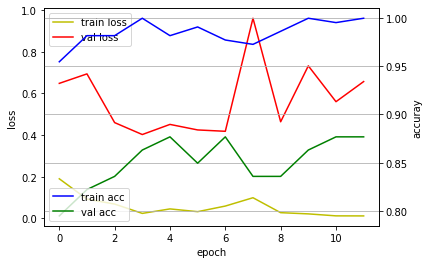

In [ ]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history['loss'], 'y', label='train loss')
loss.plot(history.history['val_loss'], 'r', label='val loss')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

In [ ]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) #test_loss, test_acc

5/5 [==============================] - 2s 434ms/step - loss: 0.4825 - accuracy: 0.8493


In [ ]:
print('loss:', round(result[0]),f"({round(result[0] - last_loss, 5)})")
print('accuracy:', round(result[1], 5), f"({round(result[1] - last_accuracy, 5)})")

loss: 0 (-1.50339)
accuracy: 0.84932 (0.54795)


In [ ]:
pred = model.predict(test_set)
y_pred = []
for i in pred:
  y_pred.append(i.argmax())
print(y_pred)

5/5 [==============================] - 2s 399ms/step
[2, 1, 7, 2, 4, 4, 6, 2, 6, 0, 7, 6, 5, 6, 0, 1, 1, 7, 0, 5, 0, 0, 4, 4, 0, 0, 3, 5, 5, 6, 6, 2, 1, 1, 5, 7, 3, 4, 2, 5, 3, 0, 0, 4, 3, 1, 4, 7, 4, 3, 5, 1, 7, 1, 5, 5, 1, 0, 7, 5, 7, 1, 2, 4, 2, 6, 2, 1, 1, 2, 4, 5, 6]


In [ ]:
len(train_set.next())
train_set.next()

(array([[[[0.9914976 , 0.0320319 , 0.02613228],
          [0.98936373, 0.03416573, 0.02186463],
          [0.98722994, 0.03428869, 0.01860241],
          ...,
          [0.21647014, 0.19633947, 0.19908449],
          [0.18482904, 0.16728534, 0.16429247],
          [0.21081637, 0.18681279, 0.18697084]],
 
         [[0.98986214, 0.02907775, 0.04351457],
          [0.99199593, 0.03121158, 0.02857779],
          [0.99018407, 0.03334541, 0.02350528],
          ...,
          [0.18061768, 0.16447061, 0.16124022],
          [0.20275527, 0.18122795, 0.1802269 ],
          [0.19886555, 0.16888656, 0.17103642]],
 
         [[0.98956275, 0.02745098, 0.06552098],
          [0.9890418 , 0.02825743, 0.04925682],
          [0.99117565, 0.03039126, 0.03432005],
          ...,
          [0.1923233 , 0.17311421, 0.17095403],
          [0.20582019, 0.17931853, 0.18030928],
          [0.1886755 , 0.15360147, 0.15664266]],
 
         ...,
 
         [[0.9814927 , 0.08975589, 0.16294514],
          [0.93643

In [ ]:
y_pred = []
for i in pred:
  y_pred.append(i.argmax())
  # print(i.argmax())

In [ ]:
# import glob
# for a in glob.glob("/content/drive/MyDrive/테스트용/val")

v = np.array(y_pred)
v - test_set.classes

array([ 4,  1,  2,  5,  5,  3,  1,  1,  6,  1,  1,  0,  5,  1,  0,  5,  6,
        5,  4, -1,  3, -2,  0,  5,  1,  3,  4,  2,  0,  4,  1, -3, -3,  4,
        1, -1, -2, -2,  1,  1,  2,  2,  3,  0, -4,  3, -5,  0, -1, -5, -2,
       -4, -5,  2, -4, -4,  0, -1, -5, -2, -5, -1, -2, -6, -2, -7, -3, -7,
       -4, -3, -6, -3, -5])

In [ ]:
test_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 7], dtype=int32)